In [1]:
# Імпорт необхідних бібліотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
from sklearn.datasets import load_iris
iris = load_iris(as_frame=True)
data = iris.frame

data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [3]:
X = data[iris.feature_names]
y = data['target']

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [5]:
X.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [6]:
y.value_counts()

target
0    50
1    50
2    50
Name: count, dtype: int64

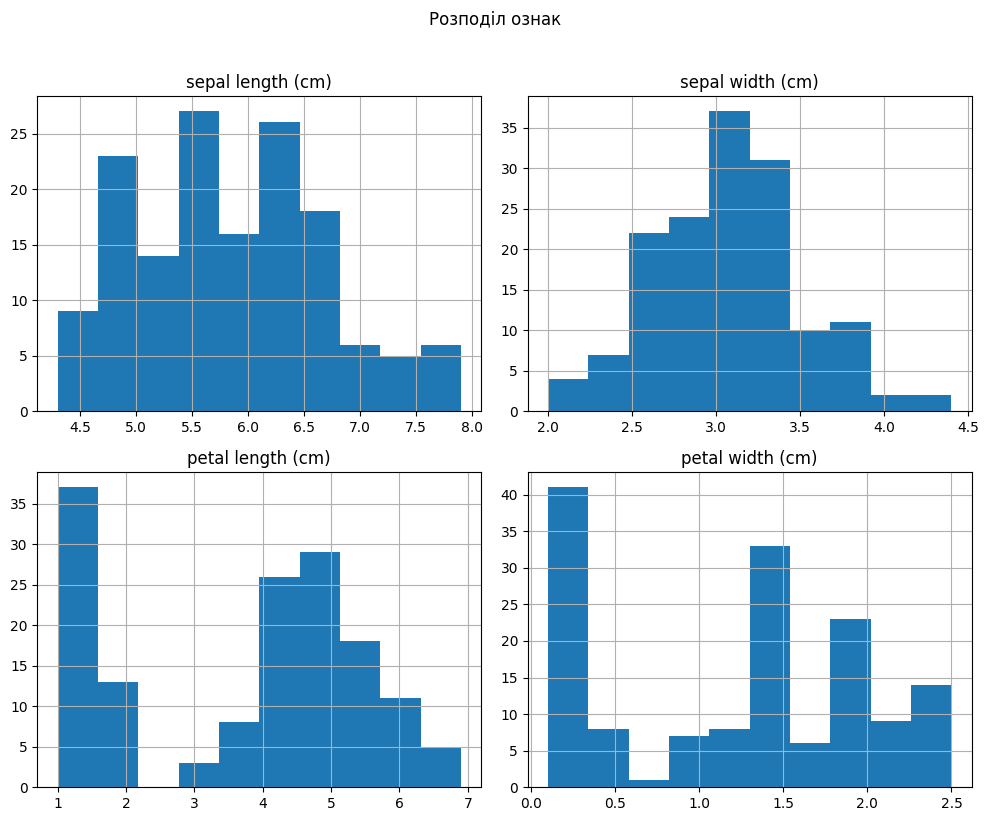

In [7]:
X.hist(figsize=(10, 8))
plt.suptitle("Розподіл ознак", y=1.02)
plt.tight_layout()
plt.show()

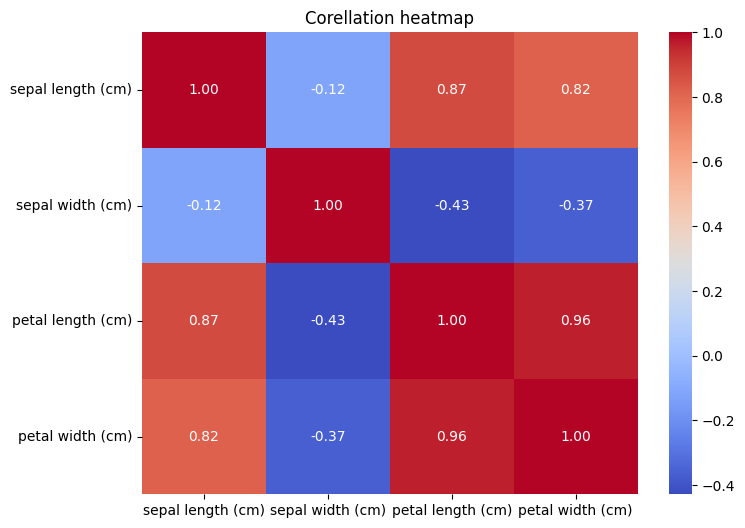

In [8]:
correlation_matrix = X.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Corellation heatmap")
plt.show()

In [9]:
#X = X.drop('petal width (cm)', axis=1)

In [10]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X[:5]

array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ],
       [-1.50652052,  0.09821729, -1.2833891 , -1.3154443 ],
       [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ]])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
encoder = OneHotEncoder(sparse_output=False)
y_train = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test = encoder.transform(y_test.values.reshape(-1, 1))

In [13]:
VALIDATION_SPLIT = 0.2
N_TRAIN = len(X_train)
N_VALIDATION = N_TRAIN * VALIDATION_SPLIT
BATCH_SIZE = 16
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [37]:
initial_learning_rate = 0.001
decay_steps = STEPS_PER_EPOCH * 50
decay_rate = 0.96
staircase = False

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=staircase
)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [38]:
import os

def get_callbacks(name = "default"):
  checkpoint_path = "training/" + name + "/checkpoint.weights.h5"

  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  save_weights_only=True,
                                                  verbose=1)
  return [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min'), cp_callback]

In [39]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy', 'accuracy'])

    model.summary()

    history = model.fit(
        X_train,
        y_train,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_split=VALIDATION_SPLIT,
        callbacks=get_callbacks(name),
        verbose=0
    )
    return history

In [40]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input

def create_model_tiny(input_shape):
    model = Sequential([
        Input(input_shape),
        BatchNormalization(),
        Dense(4, activation='relu'),
        Dense(3, activation='softmax')
    ])
    return model

def create_model_small(input_shape):
    model = Sequential([
        Input(input_shape),
        BatchNormalization(),
        Dense(8, activation='relu'),
        Dense(8, activation='relu'),
        Dense(3, activation='softmax')
    ])
    return model

def create_model_medium(input_shape):
    model = Sequential([
        Input(input_shape),
        BatchNormalization(),
        Dense(16, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(3, activation='softmax')
    ])
    return model

def create_model_large(input_shape):
    model = Sequential([
        Input(input_shape),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(3, activation='softmax')
    ])
    return model

def create_model_medium_dropout(input_shape, dropout_rate=0.1):
    model = Sequential([
        Input(input_shape),
        BatchNormalization(),
        Dense(16, activation='relu'),
        Dropout(dropout_rate),
        Dense(16, activation='relu'),
        Dropout(dropout_rate),
        Dense(8, activation='relu'),
        Dense(3, activation='softmax')
    ])
    return model

def create_model_large_dropout_l2(input_shape, dropout_rate=0.1):
    l2_factor = 0.005
    model = Sequential([
        Input(input_shape),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dropout(dropout_rate),
        Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_factor)),
        Dropout(dropout_rate),
        Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_factor)),
        Dropout(dropout_rate),
        Dense(8, activation='relu'),
        Dense(3, activation='softmax')
    ])
    return model

In [41]:
input_shape = (X_train.shape[1],)


tiny_model = create_model_tiny(input_shape)
tiny_model.summary()
history = compile_and_fit(tiny_model, name='tiny', max_epochs=100)



Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_6           │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 3)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51 (204.00 B)

 Trainable params: 43 (172.00 B)

 Non-trainable params: 8 (32.00 B)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_6           │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 3)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51 (204.00 B)

 Trainable params: 43 (172.00 B)

 Non-trainable params: 8 (32.00 B)


Epoch 1: saving model to training/tiny/checkpoint.weights.h5

Epoch 2: saving model to training/tiny/checkpoint.weights.h5

Epoch 3: saving model to training/tiny/checkpoint.weights.h5

Epoch 4: saving model to training/tiny/checkpoint.weights.h5

Epoch 5: saving model to training/tiny/checkpoint.weights.h5

Epoch 6: saving model to training/tiny/checkpoint.weights.h5

Epoch 7: saving model to training/tiny/checkpoint.weights.h5

Epoch 8: saving model to training/tiny/checkpoint.weights.h5

Epoch 9: saving model to training/tiny/checkpoint.weights.h5

Epoch 10: saving model to training/tiny/checkpoint.weights.h5

Epoch 11: saving model to training/tiny/checkpoint.weights.h5

Epoch 12: saving model to training/tiny/checkpoint.weights.h5

Epoch 13: saving model to training/tiny/checkpoint.weights.h5

Epoch 14: saving model to training/tiny/checkpoint.weights.h5

Epoch 15: saving model to training/tiny/checkpoint.weights.h5

Epoch 16: saving model to training/tiny/checkpoint.weights.h5



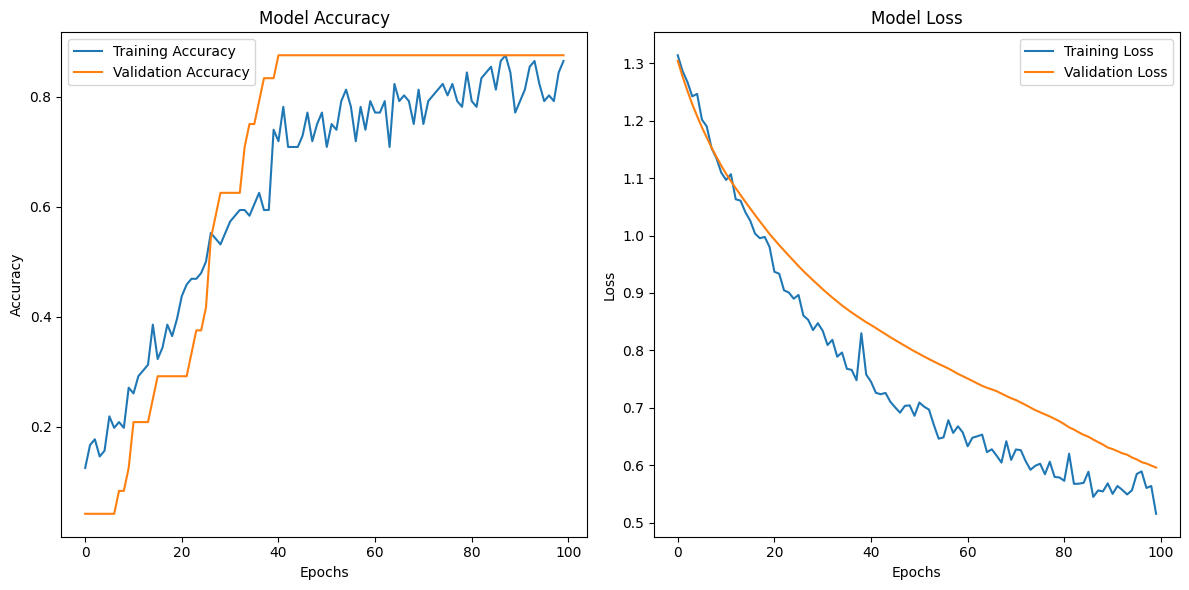

In [42]:
# Plot training and validation accuracy and loss
def draw_plot():
    plt.figure(figsize=(12, 6))

# Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

# Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

draw_plot()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_7           │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155 (620.00 B)

 Trainable params: 147 (588.00 B)

 Non-trainable params: 8 (32.00 B)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_7           │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155 (620.00 B)

 Trainable params: 147 (588.00 B)

 Non-trainable params: 8 (32.00 B)


Epoch 1: saving model to training/small/checkpoint.weights.h5

Epoch 2: saving model to training/small/checkpoint.weights.h5

Epoch 3: saving model to training/small/checkpoint.weights.h5

Epoch 4: saving model to training/small/checkpoint.weights.h5

Epoch 5: saving model to training/small/checkpoint.weights.h5

Epoch 6: saving model to training/small/checkpoint.weights.h5

Epoch 7: saving model to training/small/checkpoint.weights.h5

Epoch 8: saving model to training/small/checkpoint.weights.h5

Epoch 9: saving model to training/small/checkpoint.weights.h5

Epoch 10: saving model to training/small/checkpoint.weights.h5

Epoch 11: saving model to training/small/checkpoint.weights.h5

Epoch 12: saving model to training/small/checkpoint.weights.h5

Epoch 13: saving model to training/small/checkpoint.weights.h5

Epoch 14: saving model to training/small/checkpoint.weights.h5

Epoch 15: saving model to training/small/checkpoint.weights.h5

Epoch 16: saving model to training/small/checkpo

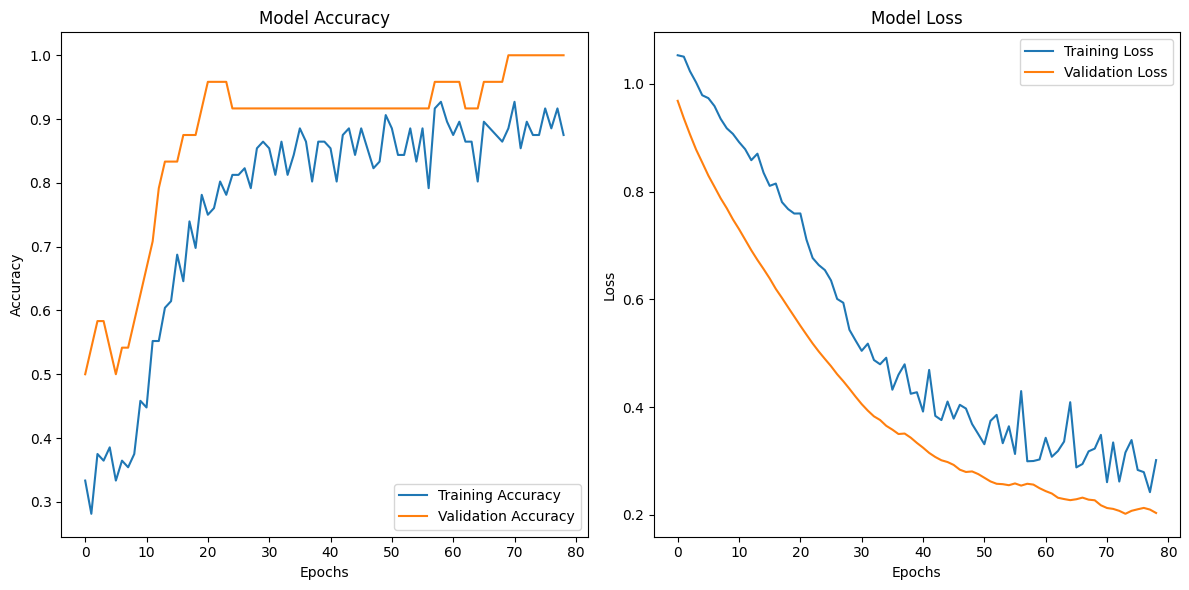

In [43]:
input_shape = (X_train.shape[1],)


small_model = create_model_small(input_shape)
small_model.summary()
history = compile_and_fit(small_model, name='small', max_epochs=100)

draw_plot()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_8           │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 531 (2.07 KB)

 Trainable params: 523 (2.04 KB)

 Non-trainable params: 8 (32.00 B)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_8           │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 531 (2.07 KB)

 Trainable params: 523 (2.04 KB)

 Non-trainable params: 8 (32.00 B)


Epoch 1: saving model to training/medium/checkpoint.weights.h5

Epoch 2: saving model to training/medium/checkpoint.weights.h5

Epoch 3: saving model to training/medium/checkpoint.weights.h5

Epoch 4: saving model to training/medium/checkpoint.weights.h5

Epoch 5: saving model to training/medium/checkpoint.weights.h5

Epoch 6: saving model to training/medium/checkpoint.weights.h5

Epoch 7: saving model to training/medium/checkpoint.weights.h5

Epoch 8: saving model to training/medium/checkpoint.weights.h5

Epoch 9: saving model to training/medium/checkpoint.weights.h5

Epoch 10: saving model to training/medium/checkpoint.weights.h5

Epoch 11: saving model to training/medium/checkpoint.weights.h5

Epoch 12: saving model to training/medium/checkpoint.weights.h5

Epoch 13: saving model to training/medium/checkpoint.weights.h5

Epoch 14: saving model to training/medium/checkpoint.weights.h5

Epoch 15: saving model to training/medium/checkpoint.weights.h5

Epoch 16: saving model to trainin

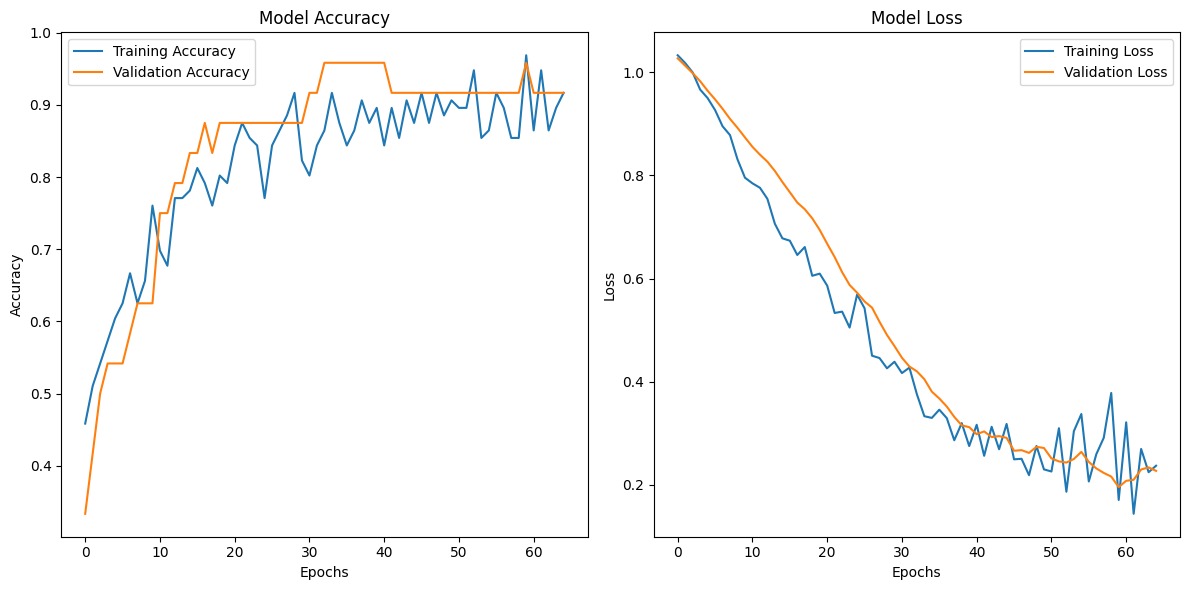

In [44]:
input_shape = (X_train.shape[1],)


medium_model = create_model_medium(input_shape)
medium_model.summary()
history = compile_and_fit(medium_model, name="medium", max_epochs=100)

draw_plot()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_9           │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 531 (2.07 KB)

 Trainable params: 523 (2.04 KB)

 Non-trainable params: 8 (32.00 B)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_9           │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 531 (2.07 KB)

 Trainable params: 523 (2.04 KB)

 Non-trainable params: 8 (32.00 B)


Epoch 1: saving model to training/medium_drop/checkpoint.weights.h5

Epoch 2: saving model to training/medium_drop/checkpoint.weights.h5

Epoch 3: saving model to training/medium_drop/checkpoint.weights.h5

Epoch 4: saving model to training/medium_drop/checkpoint.weights.h5

Epoch 5: saving model to training/medium_drop/checkpoint.weights.h5

Epoch 6: saving model to training/medium_drop/checkpoint.weights.h5

Epoch 7: saving model to training/medium_drop/checkpoint.weights.h5

Epoch 8: saving model to training/medium_drop/checkpoint.weights.h5

Epoch 9: saving model to training/medium_drop/checkpoint.weights.h5

Epoch 10: saving model to training/medium_drop/checkpoint.weights.h5

Epoch 11: saving model to training/medium_drop/checkpoint.weights.h5

Epoch 12: saving model to training/medium_drop/checkpoint.weights.h5

Epoch 13: saving model to training/medium_drop/checkpoint.weights.h5

Epoch 14: saving model to training/medium_drop/checkpoint.weights.h5

Epoch 15: saving model to tr

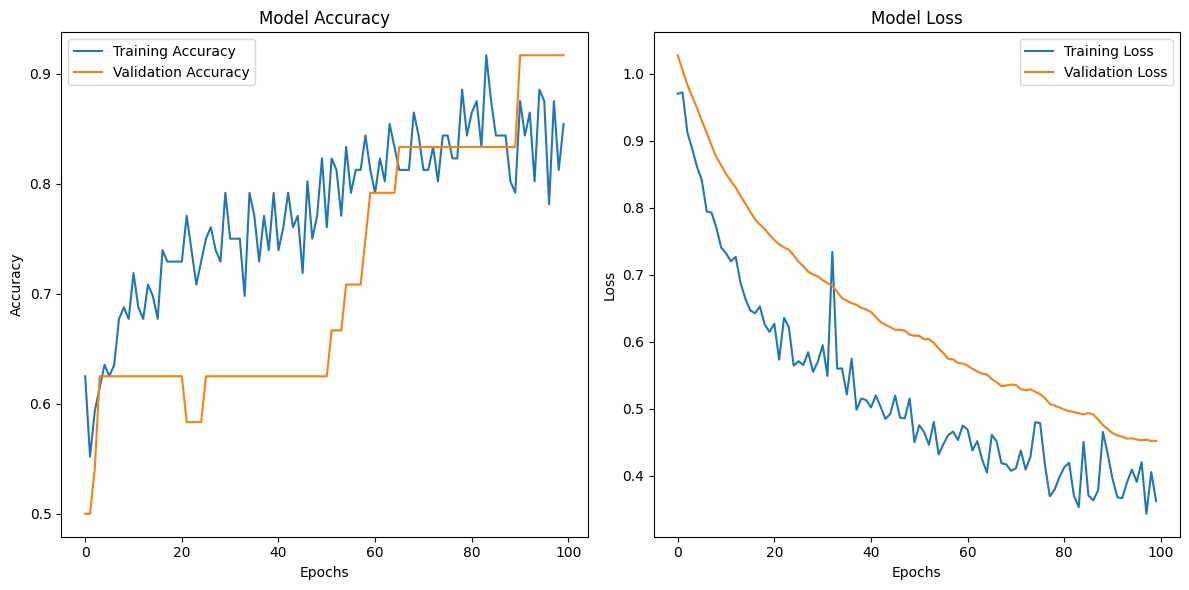

In [45]:
input_shape = (X_train.shape[1],)


medium_model_d = create_model_medium_dropout(input_shape)
medium_model_d.summary()
history = compile_and_fit(medium_model_d, name="medium_drop", max_epochs=100)

draw_plot()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_10          │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,923 (7.51 KB)

 Trainable params: 1,915 (7.48 KB)

 Non-trainable params: 8 (32.00 B)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_10          │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,923 (7.51 KB)

 Trainable params: 1,915 (7.48 KB)

 Non-trainable params: 8 (32.00 B)


Epoch 1: saving model to training/large/checkpoint.weights.h5

Epoch 2: saving model to training/large/checkpoint.weights.h5

Epoch 3: saving model to training/large/checkpoint.weights.h5

Epoch 4: saving model to training/large/checkpoint.weights.h5

Epoch 5: saving model to training/large/checkpoint.weights.h5

Epoch 6: saving model to training/large/checkpoint.weights.h5

Epoch 7: saving model to training/large/checkpoint.weights.h5

Epoch 8: saving model to training/large/checkpoint.weights.h5

Epoch 9: saving model to training/large/checkpoint.weights.h5

Epoch 10: saving model to training/large/checkpoint.weights.h5

Epoch 11: saving model to training/large/checkpoint.weights.h5

Epoch 12: saving model to training/large/checkpoint.weights.h5

Epoch 13: saving model to training/large/checkpoint.weights.h5

Epoch 14: saving model to training/large/checkpoint.weights.h5

Epoch 15: saving model to training/large/checkpoint.weights.h5

Epoch 16: saving model to training/large/checkpo

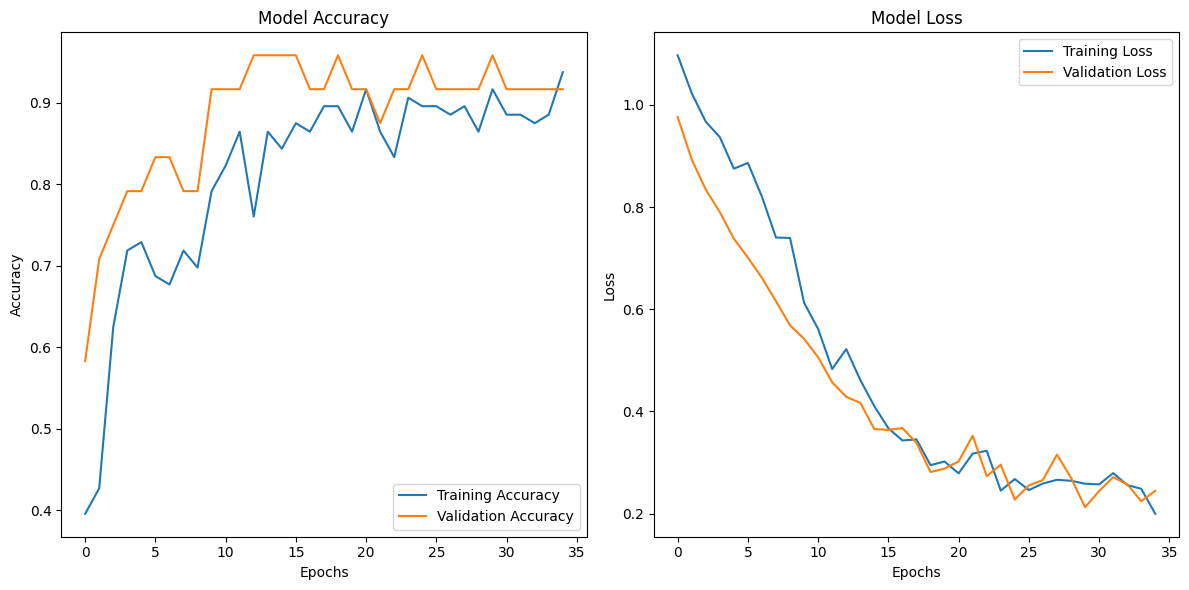

In [46]:
input_shape = (X_train.shape[1],)


large_model = create_model_large(input_shape)
large_model.summary()
history = compile_and_fit(large_model, name="large", max_epochs=100)

draw_plot()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_11          │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,923 (7.51 KB)

 Trainable params: 1,915 (7.48 KB)

 Non-trainable params: 8 (32.00 B)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_11          │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,923 (7.51 KB)

 Trainable params: 1,915 (7.48 KB)

 Non-trainable params: 8 (32.00 B)


Epoch 1: saving model to training/large_drop_l2/checkpoint.weights.h5

Epoch 2: saving model to training/large_drop_l2/checkpoint.weights.h5

Epoch 3: saving model to training/large_drop_l2/checkpoint.weights.h5

Epoch 4: saving model to training/large_drop_l2/checkpoint.weights.h5

Epoch 5: saving model to training/large_drop_l2/checkpoint.weights.h5

Epoch 6: saving model to training/large_drop_l2/checkpoint.weights.h5

Epoch 7: saving model to training/large_drop_l2/checkpoint.weights.h5

Epoch 8: saving model to training/large_drop_l2/checkpoint.weights.h5

Epoch 9: saving model to training/large_drop_l2/checkpoint.weights.h5

Epoch 10: saving model to training/large_drop_l2/checkpoint.weights.h5

Epoch 11: saving model to training/large_drop_l2/checkpoint.weights.h5

Epoch 12: saving model to training/large_drop_l2/checkpoint.weights.h5

Epoch 13: saving model to training/large_drop_l2/checkpoint.weights.h5

Epoch 14: saving model to training/large_drop_l2/checkpoint.weights.h5



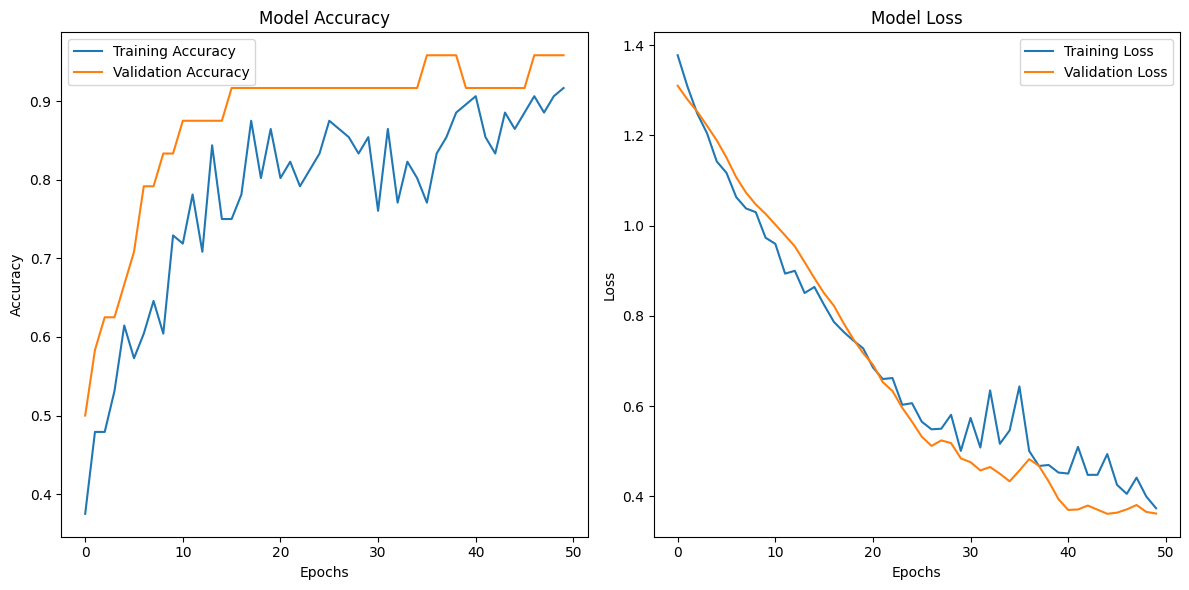

In [47]:
input_shape = (X_train.shape[1],)


large_model_d = create_model_large_dropout_l2(input_shape)
large_model_d.summary()
history = compile_and_fit(large_model_d, name="large_drop_l2", max_epochs=100)

draw_plot()

In [48]:
y_probs = medium_model.predict(X_test)
y_pred = np.argmax(y_probs, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


In [49]:
print(y_pred[:5])

[1 0 2 1 1]


In [50]:
print(y_test[:5])

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


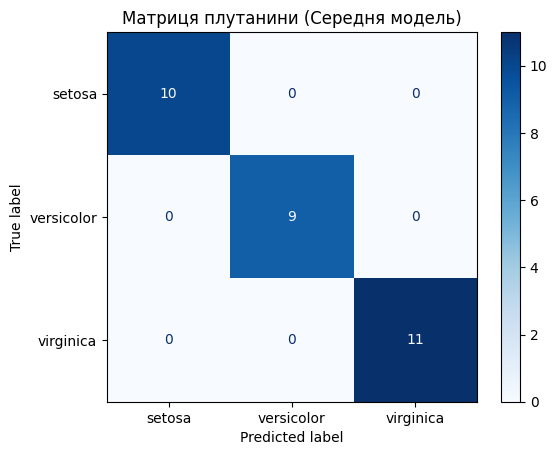


Звіт про класифікацію (Середня модель):
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



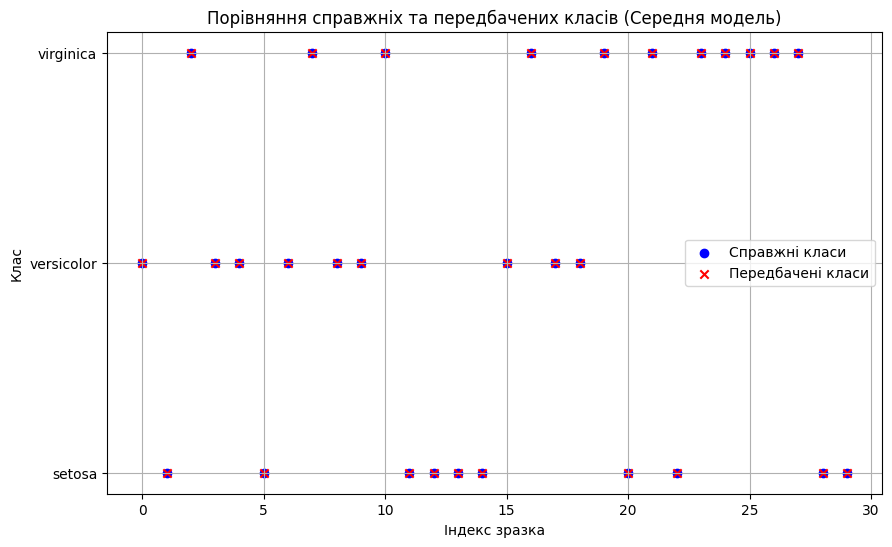

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay
y_test_mapped = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_mapped, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Матриця плутанини (Середня модель)')
plt.show()

    # Виведення звіту про класифікацію
print("\nЗвіт про класифікацію (Середня модель):")
print(classification_report(y_test_mapped, y_pred, target_names=iris.target_names))

    # Додаткова візуалізація (графік передбачень проти справжніх значень - обмежено для багатокласової класифікації)
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test_mapped)), y_test_mapped, color='blue', marker='o', label='Справжні класи')
plt.scatter(range(len(y_pred)), y_pred, color='red', marker='x', label='Передбачені класи')
plt.yticks(np.arange(len(iris.target_names)), iris.target_names)
plt.xlabel('Індекс зразка')
plt.ylabel('Клас')
plt.title('Порівняння справжніх та передбачених класів (Середня модель)')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
medium_model.save('best_iris.keras')


In [53]:
loaded_model = tf.keras.models.load_model('best_iris.keras')
loaded_model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_8           │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,578 (6.17 KB)

 Trainable params: 523 (2.04 KB)

 Non-trainable params: 8 (32.00 B)

 Optimizer params: 1,047 (4.09 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


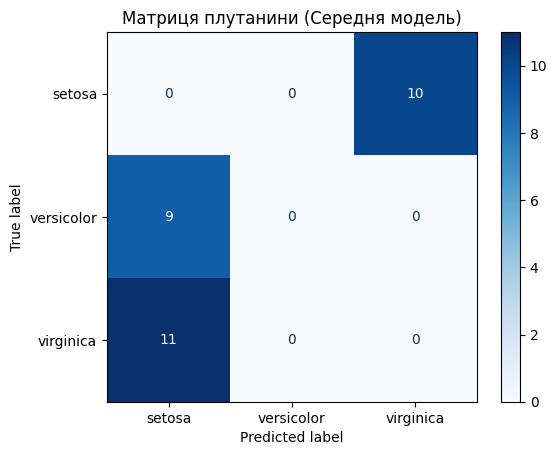

In [57]:
new_meduim_model = create_model_medium(input_shape)
new_meduim_model.save_weights("training/medium/checkpoint.weights.h5")

y_probs = new_meduim_model.predict(X_test)
y_pred = np.argmax(y_probs, axis=1)

y_test_mapped = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_mapped, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Матриця плутанини (Середня модель)')
plt.show()
